In [2]:
from utils.binaries import *
from utils.plotting import *

import polars as pl

12:27:42 (  +51.8s) [INFO   ] -- import logging
12:27:42 (  +167ms) [INFO   ] -- import numpy as np
12:27:42 (    +7ms) [INFO   ] -- import uncertainties
12:27:42 (  +277ms) [INFO   ] -- import pandas as pd
12:27:42 (    +1ms) [WARNING] -- pandas support to be dropped at some point!
12:27:42 (    +1ms) [INFO   ] -- import binaries.tools as tools
12:27:43 (  +399ms) [INFO   ] -- import matplotlib.pyplot as plt
12:27:43 (  +528ms) [INFO   ] -- import seaborn as so
12:27:43 (    +1ms) [INFO   ] -- import plotting.tools as plot
12:27:43 (    +8ms) [DEBUG  ] -- font size set to 9.5
12:27:43 (    +0ms) [DEBUG  ] -- label size set to 13.0
12:27:43 (    +1ms) [DEBUG  ] -- figure size set to [6.6, 3.3]
12:27:43 (    +1ms) [DEBUG  ] -- markersize set to 2.0
12:27:43 (    +1ms) [DEBUG  ] -- usetex set to False


In [3]:
# T3 histo files
t3_histos = pl.read_csv('/cr/data01/filip/Data/muonAcquisition/T3events/night/t3_histos.ssd',
                        has_header=False,
                        new_columns=['id', 't'],
                        separator=' ')

t3_histos = t3_histos.with_columns(
    histo=pl.concat_list(pl.exclude('id', 't'))
).select('id', 't', 'histo')

t3_histos

id,t,histo
i64,i64,list[i64]
1840,1398069000,"[1, 1089, … 0]"
1823,1398069011,"[0, 66, … 0]"
660,1398069011,"[0, 842, … 0]"
1845,1398069011,"[2, 1071, … 1]"
1839,1398069011,"[0, 742, … 0]"
…,…,…
1845,1398077151,"[0, 1066, … 0]"
1839,1398077144,"[1, 1190, … 0]"
643,1398077132,"[0, 0, … 0]"


In [4]:
# muonAcq histos

import os

def read_file(path):

    path = f'/cr/data01/filip/Data/muonAcquisition/night/' + path
    coinc_hist = lambda x : np.array([int(e.split(' ')[-4]) for e in x]) # ...
    all_hist = lambda x : np.array([int(e.split(' ')[-1]) for e in x])
    peak_histo, rates = [], []

    with open(path, 'r') as source:

        baseline = 0

        is_peak_histogram = False
        is_all_histogram = False
        for i, line in enumerate(source.readlines()):
            line = line.strip()

            if line.startswith('Offset'):
                baseline = int(line.split(' ')[-1])

            if line == 'Peak': 
                is_peak_histogram = True
                continue
            elif line == 'Charge':
                is_peak_histogram = False
            
            if is_peak_histogram: peak_histo.append(line)
            if line == '======ssd:':
                is_all_histogram = True
                continue

            if is_all_histogram: rates.append(line)

        peak_histo = np.array(coinc_hist(peak_histo))
        bin0 = int(rates[0].split(' ')[3])

    return peak_histo / 60, all_hist(rates[1:]) / 60, bin0 - baseline


peak_histos = {x : [] for x in ['659', '1840', '1823', '660', '643', '1839', '1844', '1845']}
all_histos = {x : [] for x in ['659', '1840', '1823', '660', '643', '1839', '1844', '1845']}
offsets = {x : [] for x in ['659', '1840', '1823', '660', '643', '1839', '1844', '1845']}
for i, file in enumerate(os.listdir(f'/cr/data01/filip/Data/muonAcquisition/night/')):

    timestamp, station = file.split('_')
    peak_hist, all_hist, offset = read_file(file)
    peak_histos[station].append(peak_hist)
    all_histos[station].append(all_hist)
    offsets[station].append(offset)

<Figure size 3960x1980 with 0 Axes>

<Figure size 3960x1980 with 0 Axes>

<Figure size 3960x1980 with 0 Axes>

<Figure size 3960x1980 with 0 Axes>

<Figure size 3960x1980 with 0 Axes>

<Figure size 3960x1980 with 0 Axes>

<Figure size 3960x1980 with 0 Axes>

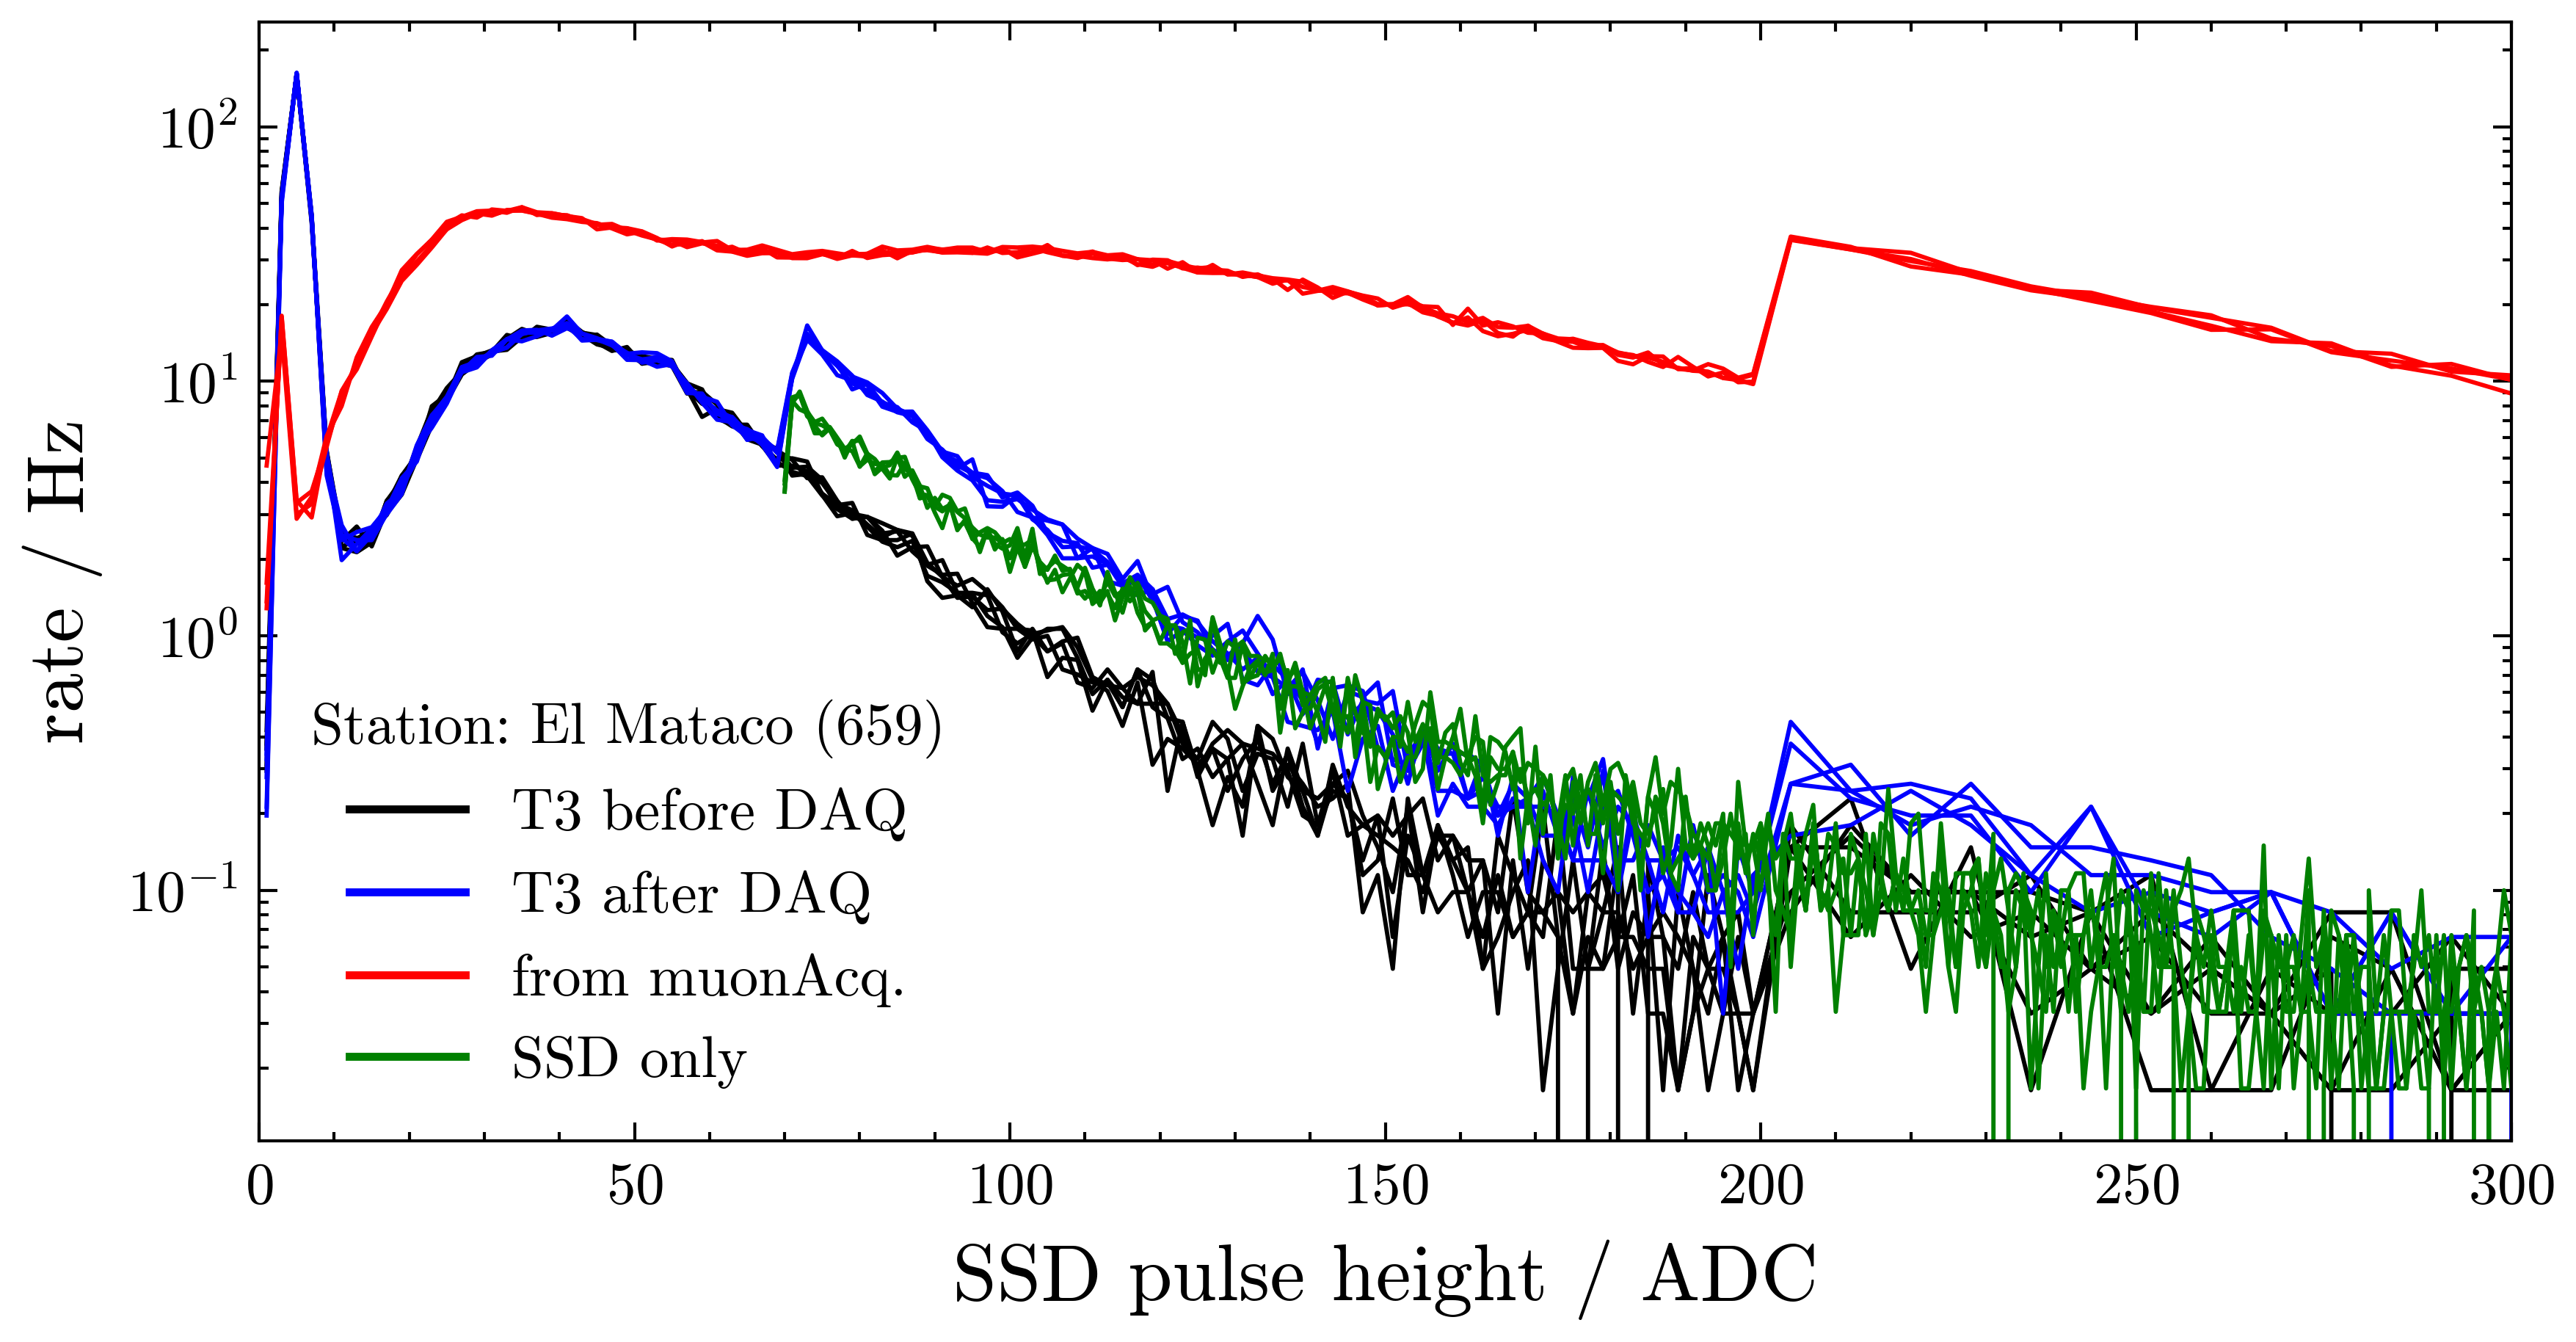

In [6]:
SSD_PEAK_HISTO_BINNING = np.array([2*k for k in range(100)] + [200 + 8*k for k in range(51)])
SSD_HISTO_BIN_CENTERS = 0.5 * (SSD_PEAK_HISTO_BINNING[1:] + SSD_PEAK_HISTO_BINNING[:-1])

id = 1840
linewidth = 0.7

names = {
    '643' : 'Borbaran',
    '1823' : 'Redondo Jr.',
    '1844' : 'Ruso Jr.',
    '1839' : 'Czech Republic',
    '1845' : 'Louisana',
    '1840' : 'Italy Jr.',
    '659' : 'El Mataco',
    # '660' : 'El Cenizo',
}
for id in names.keys():

    plt.clf()
    fig, ax = plt.subplots()
    for event in t3_histos.iter_rows():
        if event[0] != int(id): continue

        color = 'blue' if event[1] > 1398070000 else 'k'

        ax.plot(SSD_HISTO_BIN_CENTERS, np.array(event[2]) / 61, c=color, ls='solid', lw=linewidth)

    for station in list(peak_histos.keys()):
        if station != str(id): continue

        peak_hists, all_hists, offs = peak_histos[station], all_histos[station], offsets[station]

        for peak, _all, o in zip(peak_hists, all_hists, offs):
            try:
                ax.plot(SSD_HISTO_BIN_CENTERS, peak, c='r', ls='solid', lw=linewidth)
                ax.plot(range(o, o + len(_all)), _all, c='green', ls='solid', lw=linewidth)
            except ValueError: continue

    ax.plot([],[], c='k', lw=1.3, ls='solid', label='T3 before DAQ')
    ax.plot([],[], c='b', lw=1.3, ls='solid', label='T3 after DAQ')
    ax.plot([],[], c='r', lw=1.3, ls='solid', label='from muonAcq.')
    ax.plot([],[], c='g', lw=1.3, ls='solid', label='SSD only')
    ax.legend()
    ax.set_yscale('log')
    ax.set_xlim(0, 300)
    ax.set_ylabel('rate / Hz')
    ax.set_xlabel('SSD pulse height / ADC')

    leg = ax.legend(title=f'Station: {names[str(id)]} ({id})', title_fontproperties={'weight':'bold'})
    leg.get_title().set_fontweight('heavy')

    for text in leg.get_texts():
        text.set_fontweight('light')

    # plot.save(fig, f'muonAcquisition/histogram_comparison_night_{id}.png')

In [34]:
from utils.Auger.SD.UubRandoms import UubRandom

for station in ['NuriaJr', 'Nadia', 'Constanza', 'Svenja']:
    if os.path.exists(f'/cr/data01/filip/Data/UubRandomsHisto/{station}.ssd'): continue
    ssd_peak_histo = np.zeros(1000)
    DAQ_time = 0
    for ssd_traces in tools.ProgressBar(UubRandom(station, 'ssd'), newline=False):
        for trace in ssd_traces:
            DAQ_time += 2048 * 8.33e-9
            ssd_max_pulse = trace['trace'].max()
            if ssd_max_pulse < 0: continue
            if len(ssd_peak_histo) < ssd_max_pulse + 1:
                ssd_peak_histo = np.append(ssd_peak_histo, np.zeros(ssd_max_pulse - len(ssd_peak_histo) + 1))

            ssd_peak_histo[:ssd_max_pulse] += np.ones(ssd_max_pulse)

    np.savetxt(f'/cr/data01/filip/Data/UubRandomsHisto/{station}.ssd', ssd_peak_histo / DAQ_time)

(0.001, 100000.0)

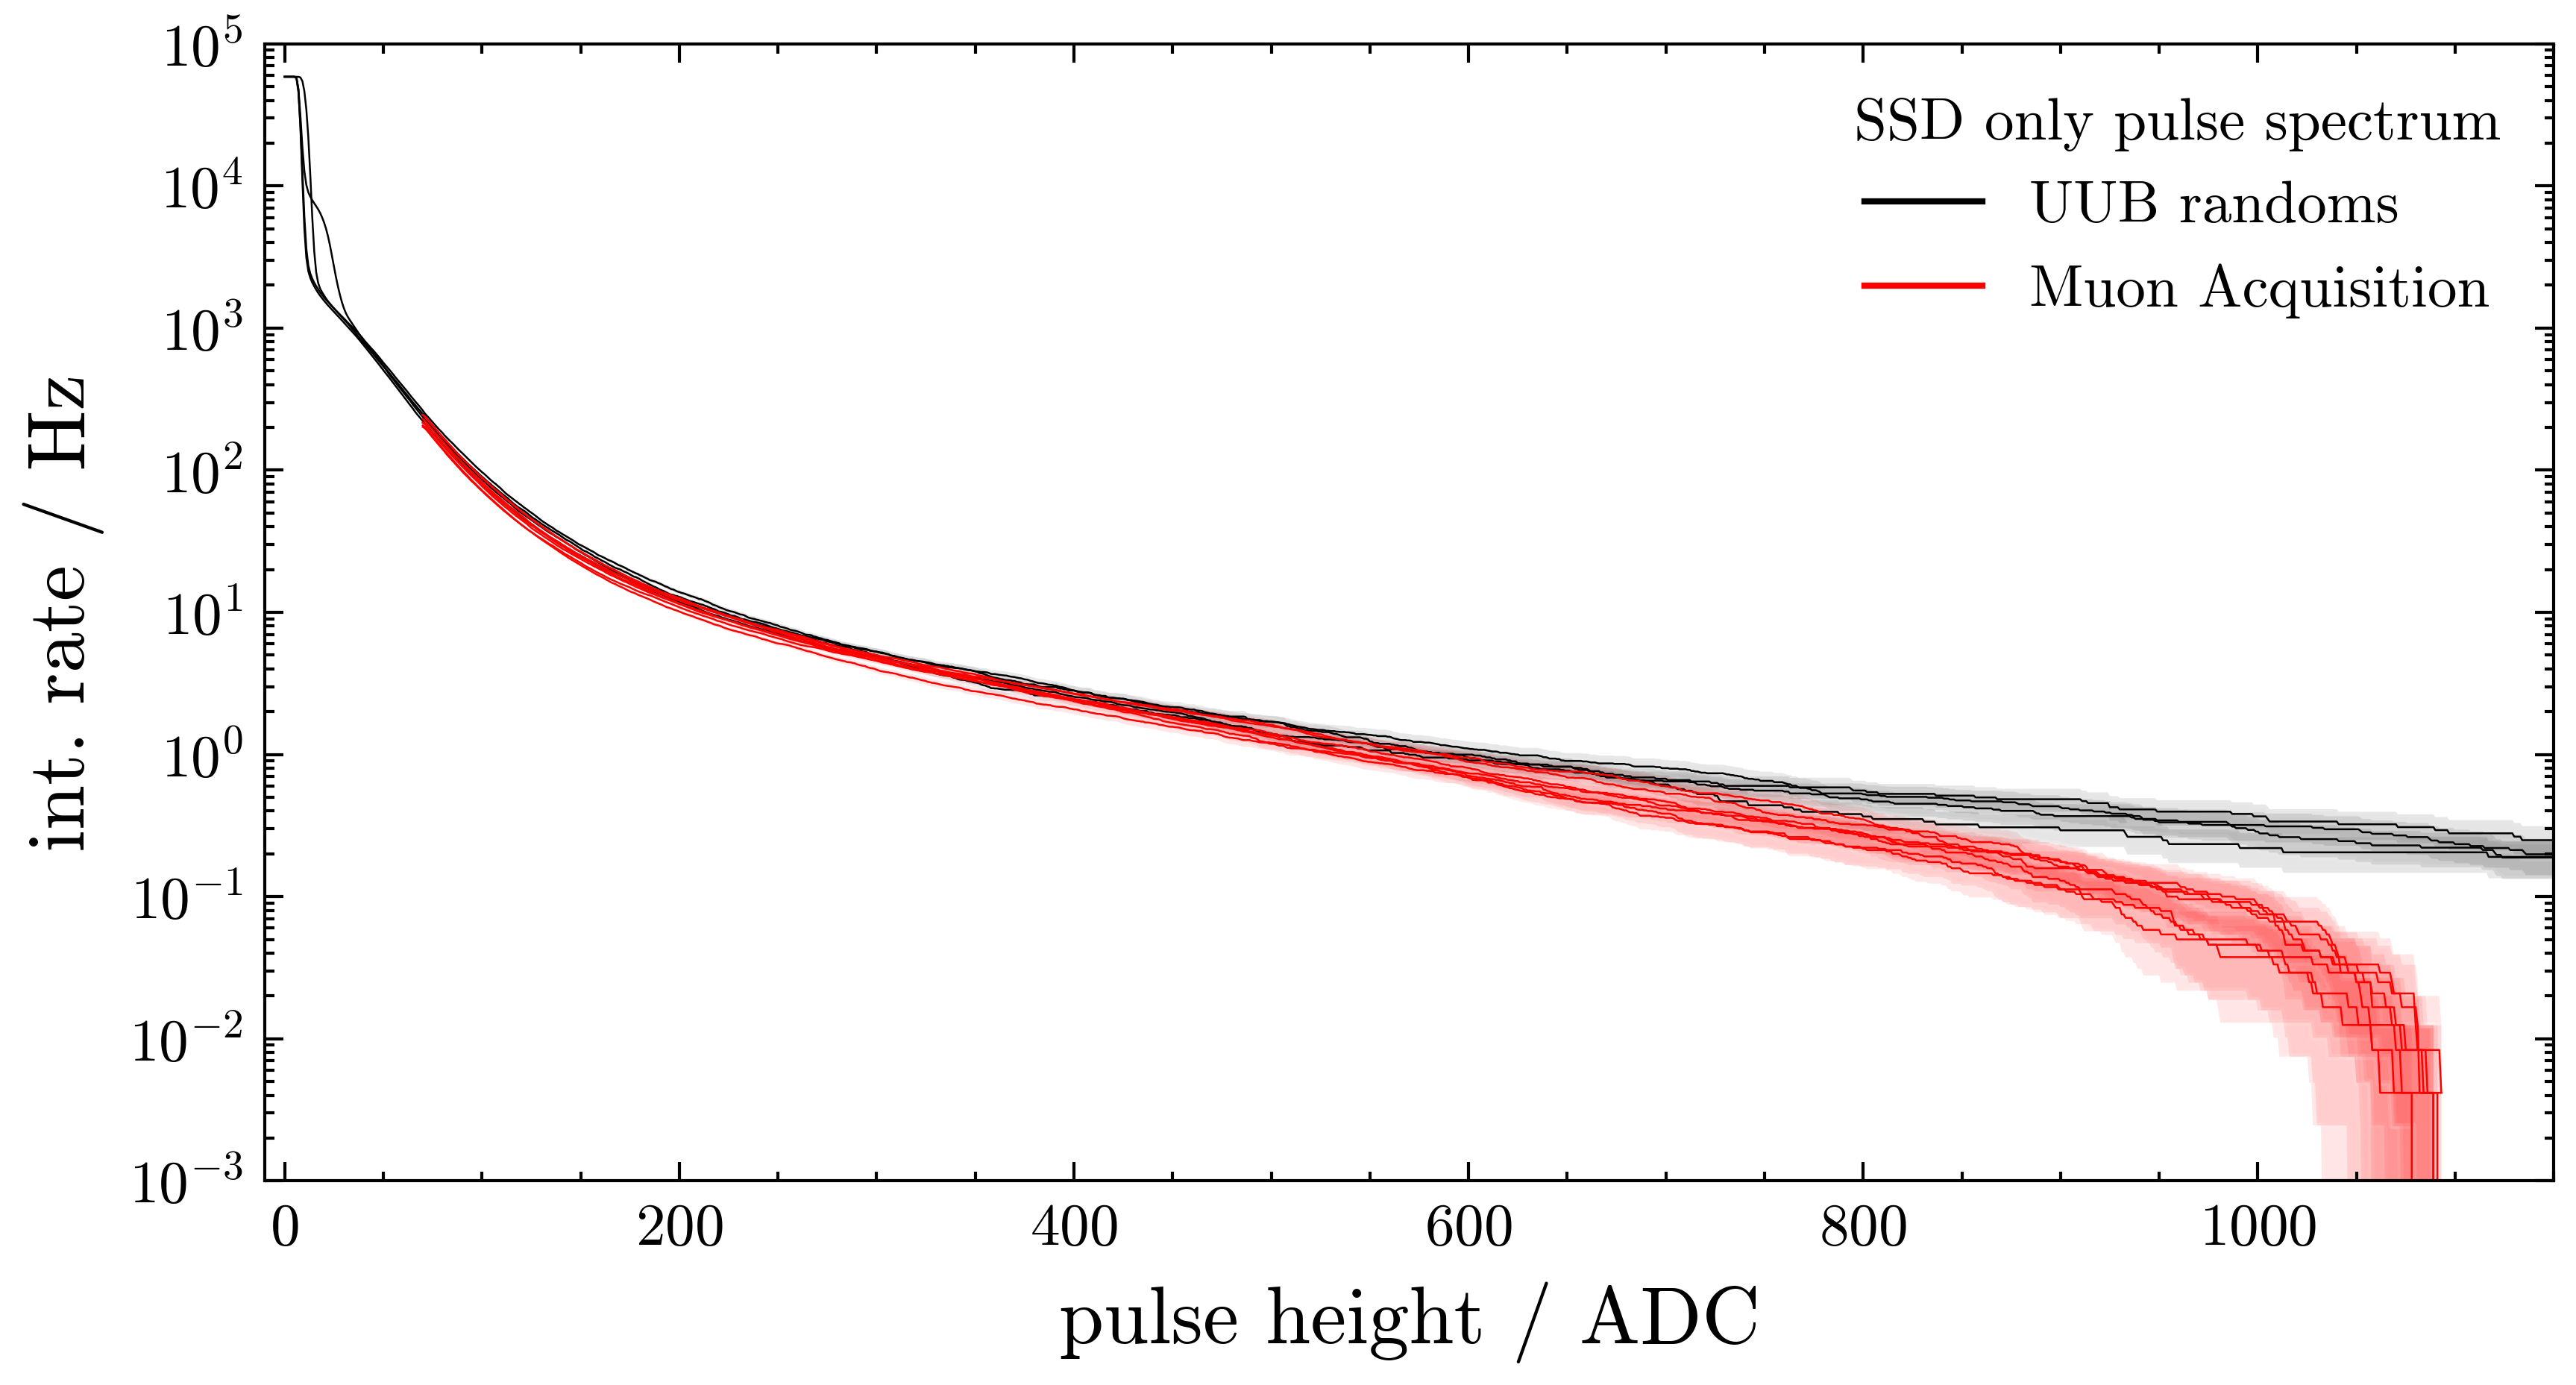

In [6]:
for station in ['Constanza', 'NuriaJr', 'Nadia', 'Svenja']:
    try:
        ssd_peak_histo = np.loadtxt(f'/cr/data01/filip/Data/UubRandomsHisto/{station}.ssd')
        _ = plt.plot(range(len(ssd_peak_histo)), ssd_peak_histo, c='k', lw=0.3, ls='solid')
        plt.fill_between(range(len(ssd_peak_histo)),
                         ssd_peak_histo - np.sqrt(ssd_peak_histo / 61),
                         ssd_peak_histo + np.sqrt(ssd_peak_histo / 61),
                         color=_[0].get_color(),
                         alpha=0.1,
                         edgecolor='w')
    except FileNotFoundError:
        pass

for station in list(peak_histos.keys()):
    if station=='660': continue

    peak_hists, all_hists, offs = peak_histos[station], all_histos[station], offsets[station]

    plt.plot(range(o, o + len(all_histos[station][0])), 
                 np.cumsum(np.mean(all_hists, axis=0)[::-1])[::-1],
                c='r', lw=0.3, ls='solid')
    plt.fill_between(range(o, o + len(all_histos[station][0])),
                     np.cumsum(np.mean(all_hists, axis=0)[::-1])[::-1] 
                     - np.cumsum((np.std(all_hists, axis=0)**2)[::-1])[::-1]
                     + np.sqrt(np.cumsum(np.mean(all_hists, axis=0)[::-1])[::-1] / 60),
                     np.cumsum(np.mean(all_hists, axis=0)[::-1])[::-1] 
                     + np.cumsum((np.std(all_hists, axis=0)**2)[::-1])[::-1]
                     - np.sqrt(np.cumsum(np.mean(all_hists, axis=0)[::-1])[::-1] / 60),
                     color='r', alpha = 0.1,
                     edgecolor='w')

plt.plot([], [], label='UUB randoms', c='k', ls='solid')
plt.plot([], [], c='r', label="Muon Acquisition", ls='solid')

plt.legend(title='SSD only pulse spectrum')
plt.yscale('log')
plt.ylabel('int. rate / Hz')
plt.xlabel('pulse height / ADC')
plt.xlim(-10, 1150)
plt.ylim(1e-3, 1e5)